In [1]:
import pandas as pd
import requests
import os
import json
import linecache
import tweepy
import copy
from PIL import Image, ImageFont, ImageDraw 
from io import BytesIO
import matplotlib.pyplot as plt
%matplotlib inline


# Gathering the data

The first step in the project is to gather all the data from the 3 different sources. I start by opening and checking the file that has been handed to me:

In [2]:
#Open the already downloaded Twitter archive
t_archive = pd.read_csv("twitter-archive-enhanced.csv")



In [3]:
t_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

The second file is accesible online. I access it and save the file in csv format.

In [4]:
#Download the image predictions and save in a file
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url)
with open ("image_predictions.tsv", mode="wb") as file:
    file.write(response.content)

In [5]:
#Open the image predictions
im_pred = pd.read_csv("image_predictions.tsv", sep="\t")
im_pred.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [9]:
im_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [6]:
#Save the data in a csv file
im_pred.to_csv("image_predictions.csv", index=False)

To create the third file, where I will store the number of favorites and retweets, I need to access twitter API and download the data using the ID of each tweet.

In [44]:
#Get the twitter data
consumer_key = ''
consumer_secret = ''
access_token = ''
access_secret = ''

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

#Save twitter data to file
myfile = open('tweet_json.txt', 'w')
for id in im_pred.tweet_id:
    try:
        tweet = api.get_status(id, tweet_mode = "extended")
        p = json.dumps(tweet._json)
        myfile.write(p+ '\n')
    except:
        pass
myfile.close()

In [47]:
#Check that the file was created by counting lines
file = open("tweet_json.txt", "r")
line_count = 0
for line in file:
    line_count += 1
file.close()

print(line_count)

2059


In [8]:
#Create a dataframe from the text file
list_tweets = []

with open("tweet_json.txt", "r") as file:
    for line in file:
        p = json.loads(line)
        list_tweets.append({"tweet_id": p["id"],
                           "retweet_count": p["retweet_count"],
                           "favorite_count": p["favorite_count"]})
        
tweet_counts = pd.DataFrame(list_tweets, columns = ["tweet_id", "retweet_count", "favorite_count"])

#Save the data in a csv file
tweet_counts.to_csv("tweet_counts.csv", index=False)

# Assesing the data

After a visual examination of the three databases and I have found several issues:

Tidyness
* timestamp column shows time and hour
* type of dog could be just one column
* the text column contains also an URL

Quality
* the data contains tweets that are replies
* the data contains retweets 
* source column has extra unuseful info
* common nouns identified as names
* dogs identified in two different categories
* pictures not showing dogs in image prediction file

Then I have also checked all the files programatically with .info():

In [7]:
t_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

It seems that not all the URLs are there (expanded_URLs shows missing values). It could have been caused by the pressence of replies and retweets that I have identified previously.  

In [10]:
im_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [11]:
tweet_counts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2059 entries, 0 to 2058
Data columns (total 3 columns):
tweet_id          2059 non-null int64
retweet_count     2059 non-null int64
favorite_count    2059 non-null int64
dtypes: int64(3)
memory usage: 48.3 KB


In the t_archive dataframe there are two numerical values extracted from the text, the numerator is the "rating" of the dog, which is always higher than 10, while the denominator should always be 10. I check the minimum and maximum of each column.

In [9]:
print(t_archive.rating_numerator.max())
print(t_archive.rating_numerator.min())
print(t_archive.rating_denominator.max())
print(t_archive.rating_denominator.min())

1776
0
170
0


So after the visual and programatic inspection I have found the following issues:

Tidiness
* timestamp column shows time and hour
* type of dog could be just one column
* the text column contains also an URL

Quality
* the data contains tweets that are replies
* the data contains retweets 
* source column has extra unuseful info
* common nouns identified as names
* dogs identified in two different categories
* pictures not showing dogs in image prediction file
* missing elements in expanded URLs
* wrong numerator rating
* wrong denominator rating

# Cleaning the data

First, I am going to create copies of the 3 databases to perform the cleaning in the copies. In this way I can go back to the original data if I make any unwanted modification during the cleaing phase.

In [13]:
t_archive_copy = copy.copy(t_archive)
im_pred_copy = copy.copy(im_pred)
tweet_counts_copy = copy.copy(tweet_counts)

Now I am going to address the issues one by one, starting with the tidiness problems. 

## Timestamp column shows data and hour

### Define

It is not a good practice to show two pieces of information in the same cell, so it needs to be split in two: date and time.

### Code

In [47]:
#change timestamp
t_archive_copy[["date", "time", "delete"]] = t_archive_copy["timestamp"].str.split(" ", expand=True)
t_archive_copy.drop(["timestamp", "delete"], axis=1, inplace=True)


### Test

In [48]:
t_archive_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 18 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
date                          2356 non-null object
time                          23

Ideally now I would address the second tidiness problem, which is that the type of dog is spread in four columns, but this particular problem is also affected by at least of the quality issues, which is that some rows show two different types of dogs. It may also be affected by replies and retweets present in the dataframe. Thus, I will fix the tidiness issue after I have cleaned the other problems. 

## The text column contains and URL

### Define

The text column contains also more than one piece of information. It has one or sometimes two shortened URLs. The first one is the URL of the tweet, and in some cases there is a second URL who refers to a differente website. I split this information in different columns.

### Code

In [49]:
#split the URL from the rest of the text
t_archive_copy[["text", "shortened_url","shortened_url_2"]] = t_archive_copy["text"].str.split("https", expand=True)

#add the separator back to the second and third items
for i, row in t_archive_copy.iterrows():
    if t_archive_copy.loc[i, "shortened_url"] != None:
        t_archive_copy.loc[i, "shortened_url"] = "https" + t_archive_copy.loc[i, "shortened_url"]
    if t_archive_copy.loc[i, "shortened_url_2"] != None:
        t_archive_copy.loc[i, "shortened_url_2"] = "https" + t_archive_copy.loc[i, "shortened_url_2"]


### Test

In [52]:

t_archive_copy[["text", "shortened_url", "shortened_url_2"]].head(10)

,text,shortened_url,shortened_url_2
0,This is Phineas. He's a mystical boy. Only eve...,https://t.co/MgUWQ76dJU,None
1,This is Tilly. She's just checking pup on you....,https://t.co/0Xxu71qeIV,None
2,This is Archie. He is a rare Norwegian Pouncin...,https://t.co/wUnZnhtVJB,None
3,This is Darla. She commenced a snooze mid meal...,https://t.co/tD36da7qLQ,None
4,This is Franklin. He would like you to stop ca...,https://t.co/AtUZn91f7f,None
5,Here we have a majestic great white breaching ...,https://t.co/kQ04fDDRmh,None
6,Meet Jax. He enjoys ice cream so much he gets ...,https://t.co/Zr4hWfAs1H,https://t.co/tVJBRMnhxl
7,When you watch your owner call another dog a g...,https://t.co/v0nONBcwxq,None
8,This is Zoey. She doesn't want to be one of th...,https://t.co/9TwLuAGH0b,None
9,This is Cassie. She is a college pup. Studying...,https://t.co/t1bfwz5S2A,None


## The data contains tweets that are replies

### Define

The tweets that are replies are not useful for the anlysis. I can easily identify them because there are two columns ("in_reply_to_status_id" and "in_reply_to_user_id") that are used specifically for replies. I delete all the rows that show a value in one of this columns.

### Define

In [53]:
#eliminate replies
t_archive_copy = t_archive_copy[t_archive_copy["in_reply_to_status_id"].isnull()]


### Test

In [54]:
t_archive_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2278 entries, 0 to 2355
Data columns (total 20 columns):
tweet_id                      2278 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
source                        2278 non-null object
text                          2278 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2274 non-null object
rating_numerator              2278 non-null int64
rating_denominator            2278 non-null int64
name                          2278 non-null object
doggo                         2278 non-null object
floofer                       2278 non-null object
pupper                        2278 non-null object
puppo                         2278 non-null object
date                          2278 non-null object
time                          2278

In [55]:
#Remove columns related to replies
t_archive_copy.drop(["in_reply_to_status_id", "in_reply_to_user_id"], axis=1, inplace=True)

## The data contains retweets

### Define

As it happen with the previous issue, some of the columns are specific for retweets, so I can use them to delete all the retweets. 

### Code

In [56]:
#eliminate retweets
t_archive_copy = t_archive_copy[t_archive_copy["retweeted_status_id"].isnull()]


### Test

In [57]:
t_archive_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 18 columns):
tweet_id                      2097 non-null int64
source                        2097 non-null object
text                          2097 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2094 non-null object
rating_numerator              2097 non-null int64
rating_denominator            2097 non-null int64
name                          2097 non-null object
doggo                         2097 non-null object
floofer                       2097 non-null object
pupper                        2097 non-null object
puppo                         2097 non-null object
date                          2097 non-null object
time                          2097 non-null object
shortened_url                 2094 non-null object
shortened_url_2               28 non

In [58]:
#remove columns related to retweets
t_archive_copy.drop(["retweeted_status_id", "retweeted_status_user_id", "retweeted_status_timestamp"], axis=1, inplace=True)

## Dogs identified in two different categories

### Define

There are some rows that have more than one type of dog. To identify them I am going to replace the current values (type of dog or "None") with a binary system where 1 means that this is the correct type of dog. Then I can add the values and find all the columns with more than one type of dog.

### Code

In [59]:
t_archive_copy.doggo.replace(["doggo", "None"], [1, 0], inplace=True)
t_archive_copy.floofer.replace(["floofer", "None"], [1, 0], inplace=True)
t_archive_copy.pupper.replace(["pupper", "None"], [1, 0], inplace=True)
t_archive_copy.puppo.replace(["puppo", "None"], [1, 0], inplace=True)
#Check that all the values have been changed to 0 or 1
print(t_archive_copy.doggo.unique())
print(t_archive_copy.floofer.unique())
print(t_archive_copy.pupper.unique())
print(t_archive_copy.puppo.unique())

[0 1]
[0 1]
[0 1]
[0 1]


In [60]:
#Find the columns with more than one type of dog
t_archive_copy['number_types'] = t_archive_copy['doggo'] + t_archive_copy['floofer'] + t_archive_copy["pupper"] + t_archive_copy["puppo"]
t_archive_copy[t_archive_copy.number_types > 1]


,tweet_id,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,date,time,shortened_url,shortened_url_2,number_types
191,855851453814013952,"<a href=""http://twitter.com/download/iphone"" r...",Here's a puppo participating in the #ScienceMa...,https://twitter.com/dog_rates/status/855851453...,13,10,None,1,0,0,1,2017-04-22,18:31:02,https://t.co/cMhq16isel,None,2
200,854010172552949760,"<a href=""http://twitter.com/download/iphone"" r...","At first I thought this was a shy doggo, but i...",https://twitter.com/dog_rates/status/854010172...,11,10,None,1,1,0,0,2017-04-17,16:34:26,https://t.co/TXdT3tmuYk,None,2
460,817777686764523521,"<a href=""http://twitter.com/download/iphone"" r...","This is Dido. She's playing the lead role in ""...",https://twitter.com/dog_rates/status/817777686...,13,10,Dido,1,0,1,0,2017-01-07,16:59:28,https://t.co/m7isZrOBX7,None,2
531,808106460588765185,"<a href=""http://twitter.com/download/iphone"" r...",Here we have Burke (pupper) and Dexter (doggo)...,https://twitter.com/dog_rates/status/808106460...,12,10,None,1,0,1,0,2016-12-12,00:29:28,https://t.co/ANBpEYHaho,None,2
575,801115127852503040,"<a href=""http://twitter.com/download/iphone"" r...",This is Bones. He's being haunted by another d...,https://twitter.com/dog_rates/status/801115127...,12,10,Bones,1,0,1,0,2016-11-22,17:28:25,https://t.co/55Dqe0SJNj,None,2
705,785639753186217984,"<a href=""http://twitter.com/download/iphone"" r...",This is Pinot. He's a sophisticated doggo. You...,https://twitter.com/dog_rates/status/785639753...,10,10,Pinot,1,0,1,0,2016-10-11,00:34:48,https://t.co/f2wmLZTPHd,None,2
733,781308096455073793,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...","Pupper butt 1, Doggo 0. Both 12/10",https://vine.co/v/5rgu2Law2ut,12,10,None,1,0,1,0,2016-09-29,01:42:20,https://t.co/WQvcPEpH2u,None,2
889,759793422261743616,"<a href=""http://twitter.com/download/iphone"" r...","Meet Maggie &amp; Lila. Maggie is the doggo, L...",https://twitter.com/dog_rates/status/759793422...,12,10,Maggie,1,0,1,0,2016-07-31,16:50:42,https://t.co/MYwR4DQKll,None,2
956,751583847268179968,"<a href=""http://twitter.com/download/iphone"" r...",Please stop sending it pictures that don't eve...,https://twitter.com/dog_rates/status/751583847...,5,10,None,1,0,1,0,2016-07-09,01:08:47,https://t.co/u2c9c7qSg8,None,2
1063,741067306818797568,"<a href=""http://twitter.com/download/iphone"" r...",This is just downright precious af. 12/10 for ...,https://twitter.com/dog_rates/status/741067306...,12,10,just,1,0,1,0,2016-06-10,00:39:48,https://t.co/o5J479bZUC,None,2


There are 11 instances where I have found this problem. Sometimes the reason is that two different types of dogs are mentioned in the text, althugh only one refers to the actual dog of the tweet, and sometimes there are two dogs in the picture. I have fixed this problem manually. When there are more than one dog I have removed both types from the data, as there are not many instances of this and this information could interfere with future analysis.

In [61]:
t_archive_copy.loc[191,"doggo"] = 0
t_archive_copy.loc[200, "doggo"] = 0
t_archive_copy.loc[460, "doggo"] = 0
t_archive_copy.loc[531, "doggo"] = 0
t_archive_copy.loc[531, "pupper"] = 0
t_archive_copy.loc[575, "doggo"] = 0
t_archive_copy.loc[705, "pupper"] = 0
t_archive_copy.loc[733, "pupper"] = 0
t_archive_copy.loc[733, "doggo"] = 0
t_archive_copy.loc[889, "pupper"] = 0
t_archive_copy.loc[889, "doggo"] = 0
t_archive_copy.loc[956, "pupper"] = 0
t_archive_copy.loc[956, "doggo"] = 0
t_archive_copy.loc[1063, "pupper"] = 0
t_archive_copy.loc[1063, "doggo"] = 0
t_archive_copy.loc[1113, "pupper"] = 0
t_archive_copy.loc[1113, "doggo"] = 0

### Test

In [62]:
#Check that the problem is fixed
t_archive_copy['number_types'] = t_archive_copy['doggo'] + t_archive_copy['floofer'] + t_archive_copy["pupper"] + t_archive_copy["puppo"]
t_archive_copy[t_archive_copy.number_types > 1]

,tweet_id,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,date,time,shortened_url,shortened_url_2,number_types


## Type of dog could be just one column

### Define

Now that I am sure that no row has more than one type of dog, I can create a new column and store in it the information for the type of dog for each row.

### Code

In [63]:
dog_types = t_archive_copy[["doggo", "floofer", "pupper", "puppo"]]
type = []
#Check if there is one type of dog in the row, then store it in list
for i, row in dog_types.iterrows():
    if dog_types.loc[i, ].sum() == 0:
        type.append(None)
    else:
        type.append(dog_types.loc[i,].idxmax(axis=1))
#Make a new column from the list with the stored values       
t_archive_copy["type"] = type


### Test

In [64]:
t_archive_copy["type"].head(20)

0      None
1      None
2      None
3      None
4      None
5      None
6      None
7      None
8      None
9     doggo
10     None
11     None
12    puppo
13     None
14    puppo
15     None
16     None
17     None
18     None
20     None
Name: type, dtype: object

Now I can remove all the columns I no longer need.

In [65]:
t_archive_copy.drop(["doggo", "floofer", "pupper", "puppo", "number_types"], axis=1, inplace=True)


## Source column has extra unuseful info

### Define

The column Source have some characters that provide no information. 

### Code

In [66]:
#Check all the unique values in the column source
t_archive_copy["source"].unique()

array([ '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>',
       '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>'], dtype=object)

The information I want to delete is between the "<" and ">" symbols, and the importante text is always in the same position, so I can split the string and keep the part I want:

In [67]:
#Make both symbols equal, split by it and keep the important part.
t_archive_copy["source"] = t_archive_copy["source"].str.replace("<", ">").str.split(">").str[2]

### Test

In [68]:
t_archive_copy["source"].head()

0    Twitter for iPhone
1    Twitter for iPhone
2    Twitter for iPhone
3    Twitter for iPhone
4    Twitter for iPhone
Name: source, dtype: object

# Common nouns identified as names


### Define

There are some common words in the "name" column. I will remove them by keeping only the values that start with a capital letter.

### Code

In [69]:
#Remove values starting with a lower letter
for i, row in t_archive_copy.iterrows():
    if t_archive_copy.loc[i, "name"][0].islower():
        t_archive_copy.loc[i, "name"] = None



### Test

In [70]:
t_archive_copy.name

0        Phineas
1          Tilly
2         Archie
3          Darla
4       Franklin
5           None
6            Jax
7           None
8           Zoey
9         Cassie
10          Koda
11         Bruno
12          None
13           Ted
14        Stuart
15        Oliver
16           Jim
17          Zeke
18       Ralphus
20        Gerald
21       Jeffrey
22          None
23        Canela
24          None
25          None
26          Maya
27        Mingus
28         Derek
29        Roscoe
31       Waffles
          ...   
2326        None
2327        None
2328        None
2329        None
2330        None
2331        None
2332        None
2333        None
2334        None
2335        None
2336        None
2337        None
2338        None
2339        None
2340        None
2341        None
2342        None
2343        None
2344        None
2345        None
2346        None
2347        None
2348        None
2349        None
2350        None
2351        None
2352        None
2353        No

## Pictures not showing dogs in image prediction file

### Define

Some of the images in the im_pred file do not correspond to dogs. I am going to use the result from the prediction to delete these rows, keeping only the rows that can identify a dog in one of the 3 first predictions.

In [71]:
im_pred_copy = im_pred_copy[(im_pred_copy.p1_dog == True) | (im_pred_copy.p2_dog == True) | (im_pred_copy.p3_dog == True)]

### Test

In [72]:
im_pred_copy[(im_pred_copy.p1_dog == False) & (im_pred_copy.p2_dog == False) &(im_pred_copy.p3_dog == False)]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


## Missing elements in expanded URLs

### Define

During the asses I saw that some rows were lacking the expanded URL. I check again to see if the previous modifications have affected these rows or they are still in the dataframe.

In [73]:
t_archive_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2097 non-null int64
source                2097 non-null object
text                  2097 non-null object
expanded_urls         2094 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  1993 non-null object
date                  2097 non-null object
time                  2097 non-null object
shortened_url         2094 non-null object
shortened_url_2       28 non-null object
type                  330 non-null object
dtypes: int64(3), object(9)
memory usage: 293.0+ KB


There are still 3 rows which lack the expanded URL. There are also 3 rows which lack the shortened URL. 

### Code

First I check if these three rows are the same.

In [74]:
print(t_archive_copy.name[t_archive_copy.expanded_urls.isna()])
print(t_archive_copy.name[t_archive_copy.shortened_url.isna()])

375     None
707     None
1445    None
Name: name, dtype: object
375     None
707     None
1445    None
Name: name, dtype: object


They are indeed the same and it is weird they all lack the name. I have checked them manually and I have seen that the first one looks like a proper one, the reason it lacks the name it that there are actually 2 names in the text. I don't think the other two are legit dog ratings, so I have removed them.

In [75]:
t_archive_copy.drop([707,1445], axis="index",inplace=True)


### Test

In [76]:
t_archive_copy[t_archive_copy.expanded_urls.isna()]

,tweet_id,source,text,expanded_urls,rating_numerator,rating_denominator,name,date,time,shortened_url,shortened_url_2,type
375,828361771580813312,Twitter Web Client,Beebop and Doobert should start a band 12/10 w...,NaN,12,10,None,2017-02-05,21:56:51,None,None,None


## Wrong denominator rating

### Define

We know that the "rating_denominator" column should be 10 in all the cases, so it is easy to check how many rows have a problem with this column.

### Code

In [77]:
t_archive_copy[t_archive_copy["rating_denominator"] != 10].shape[0]

17

The only way to see the problem is to check these columns manually. I have seen that in some cases there are several dogs, so they use an aggregated score. In other cases the problems was that in the text there was another instance of "n/n" (n means any number), that was misstaken as the rating. 
If we would want to analyze the rating of the dogs, having aggregated ratings would be a problem, so I have eliminated these. I have also manually inputed the cases where the right rating was missidentified. 

In [78]:
t_archive_copy.loc[433,["rating_numerator","rating_denominator"]] = None
t_archive_copy.loc[516,["rating_numerator","rating_denominator"]] = None
t_archive_copy.loc[902,["rating_numerator","rating_denominator"]] = None
t_archive_copy.loc[1068,["rating_numerator","rating_denominator"]] = [14,10]
t_archive_copy.loc[1120,["rating_numerator","rating_denominator"]] = None
t_archive_copy.loc[1165,["rating_numerator","rating_denominator"]] = [14,10]
t_archive_copy.loc[1202,["rating_numerator","rating_denominator"]] = [11,10]
t_archive_copy.loc[1228,["rating_numerator","rating_denominator"]] = None
t_archive_copy.loc[1254,["rating_numerator","rating_denominator"]] = None
t_archive_copy.loc[1274,["rating_numerator","rating_denominator"]] = None
t_archive_copy.loc[1351,["rating_numerator","rating_denominator"]] = None
t_archive_copy.loc[1433,["rating_numerator","rating_denominator"]] = None
t_archive_copy.loc[1635,["rating_numerator","rating_denominator"]] = None
t_archive_copy.loc[1662,["rating_numerator","rating_denominator"]] = [10,10]
t_archive_copy.loc[1779,["rating_numerator","rating_denominator"]] = None
t_archive_copy.loc[1843,["rating_numerator","rating_denominator"]] = None
t_archive_copy.loc[2335,["rating_numerator","rating_denominator"]] = [9,10]

### Test

In [79]:
t_archive_copy["rating_denominator"].unique()

array([ 10.,  nan])

## Wrong rating numerator

### Define

Some of the values in "rating_numerator" are higher than 15 or lower than 10, which I didn't expect. I am going to check if there is any issues related to these values.

### Code

In [81]:
#Check too high numerators
high_numerator = t_archive_copy[t_archive_copy["rating_numerator"] > 15]
high_numerator

,tweet_id,source,text,expanded_urls,rating_numerator,rating_denominator,name,date,time,shortened_url,shortened_url_2,type
695,786709082849828864,Twitter for iPhone,"This is Logan, the Chow who lived. He solemnly...",https://twitter.com/dog_rates/status/786709082...,75.0,10.0,Logan,2016-10-13,23:23:56,https://t.co/yBO5wuqaPS,None,None
763,778027034220126208,Twitter for iPhone,This is Sophie. She's a Jubilant Bush Pupper. ...,https://twitter.com/dog_rates/status/778027034...,27.0,10.0,Sophie,2016-09-20,00:24:34,https://t.co/QFaUiIHxHq,None,pupper
979,749981277374128128,TweetDeck,This is Atticus. He's quite simply America af....,https://twitter.com/dog_rates/status/749981277...,1776.0,10.0,Atticus,2016-07-04,15:00:45,https://t.co/GRXwMxLBkh,None,None
1712,680494726643068929,Twitter for iPhone,Here we have uncovered an entire battalion of ...,https://twitter.com/dog_rates/status/680494726...,26.0,10.0,None,2015-12-25,21:06:00,https://t.co/eNm2S6p9BD,None,None
2074,670842764863651840,Twitter for iPhone,After so many requests... here you go.\n\nGood...,https://twitter.com/dog_rates/status/670842764...,420.0,10.0,None,2015-11-29,05:52:33,https://t.co/yfAAo1gdeY,None,None


I have checked this 5 issues and I have seen that 3 of them are caused because there has been a problem extracting decimal numbers, only the decimal part has been taking into account. The other two cases are a picture that is not a dog and a picture with several dogs in int. I fix the issue with the decinal numbers and remove the others, which could affect the analysis.

In [82]:
for i in high_numerator.index:
    t_archive_copy.loc[i,"rating_numerator"] = float(t_archive_copy.loc[i, "text"].split("/10")[0].rsplit(" ")[-1])
#Remove the wrong rows
t_archive_copy.drop([979,2074], axis="index",inplace=True)    

### Test

In [83]:
t_archive_copy[t_archive_copy["rating_numerator"] > 15]


,tweet_id,source,text,expanded_urls,rating_numerator,rating_denominator,name,date,time,shortened_url,shortened_url_2,type


### Code

The number of cases where the numerator is lower than 10 is quite high:

In [84]:
t_archive_copy[t_archive_copy["rating_numerator"] < 8].shape[0]

165

Checking this cases I have seen there are too many reasons: mistakes extracting the numbers, pictures of other animals, jokes... I think that fixing all these issues would involve manually checking all affected rows, which is probably too much hassle for this project. Besides, the fact that this is not a "serious" rating system makes it often more complicated than a proper dataset. Thus, I consider this dataframe clean and go to the next step: merging the dataframes.

## Merging the dataframes

I use the "tweet_id" column to merge the 3 dataframes into a single one with the rows that appear in all the dataframes.

In [85]:
twitter_archive_master = pd.merge(t_archive_copy, im_pred_copy, on='tweet_id')
twitter_archive_master = pd.merge(twitter_archive_master, tweet_counts_copy, on='tweet_id')
twitter_archive_master.to_csv("twitter_archive_master.csv")
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1659 entries, 0 to 1658
Data columns (total 25 columns):
tweet_id              1659 non-null int64
source                1659 non-null object
text                  1659 non-null object
expanded_urls         1659 non-null object
rating_numerator      1648 non-null float64
rating_denominator    1648 non-null float64
name                  1579 non-null object
date                  1659 non-null object
time                  1659 non-null object
shortened_url         1659 non-null object
shortened_url_2       26 non-null object
type                  251 non-null object
jpg_url               1659 non-null object
img_num               1659 non-null int64
p1                    1659 non-null object
p1_conf               1659 non-null float64
p1_dog                1659 non-null bool
p2                    1659 non-null object
p2_conf               1659 non-null float64
p2_dog                1659 non-null bool
p3                    1659 non-null ob

I have merged them is a way that I only keep the rows that are present in the 3 different dataframes. I can check if I have lost many rows in the way.

In [86]:
print("t_archive - number of rows: ", t_archive_copy.shape[0])
print("im_pred - number of rows: ", im_pred_copy.shape[0])
print("tweet_counts - number of rows: ", tweet_counts_copy.shape[0])
print("twitter_archive_master - number of rows: ", twitter_archive_master.shape[0])

t_archive - number of rows:  2093
im_pred - number of rows:  1751
tweet_counts - number of rows:  2059
twitter_archive_master - number of rows:  1659


I can see that I have indeed lost some of the rows. I will continue working with this file anyway, but I will create another one which contains all the information:

In [87]:
twitter_archive_master_complete = pd.merge(t_archive_copy, im_pred_copy, on='tweet_id', how="outer")
twitter_archive_master_complete = pd.merge(twitter_archive_master_complete, tweet_counts_copy, on='tweet_id', how="outer")
twitter_archive_master_complete.to_csv("twitter_archive_master_complete.csv")
print("t_archive - number of rows: ", t_archive_copy.shape[0])
print("im_pred - number of rows: ", im_pred_copy.shape[0])
print("tweet_counts - number of rows: ", tweet_counts_copy.shape[0])
print("twitter_archive_master_complete - number of rows: ", twitter_archive_master_complete.shape[0])

t_archive - number of rows:  2093
im_pred - number of rows:  1751
tweet_counts - number of rows:  2059
twitter_archive_master_complete - number of rows:  2197


# Insights

Now that I have the final dataframe, I can get some insights about the data. For example, I could see which type of dog gets a higher rating. This is not an accurate measurement, as most of the dogs types are not identified, but it works as an example of what can be done with this kind of data.

In [38]:
real_dogs = twitter_archive_master[twitter_archive_master.p1_dog == True]
real_dogs = real_dogs[~real_dogs.type.isnull()]

for type_dog in real_dogs.type.unique():
    print(type_dog, ": ", real_dogs[real_dogs["type"] == type_dog].rating_numerator.mean())

doggo :  12.0
puppo :  12.05
pupper :  10.9744520548
floofer :  11.875


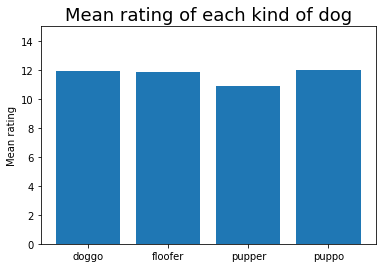

In [130]:
identified_dogs = twitter_archive_master[~twitter_archive_master.type.isnull()]

rating_by_type = {}

for type_dog in identified_dogs.type.unique():
    rating_by_type[type_dog] = identified_dogs[identified_dogs["type"] == type_dog].rating_numerator.mean()

plt.bar(rating_by_type.keys(), rating_by_type.values());
plt.ylim([0,15]);
plt.title("Mean rating of each kind of dog", fontsize = 18);
plt.ylabel("Mean rating");
plt.savefig('rating_by_type.png')

Dogs clasiffied as pupper seem to have a lower rating than the other 3 categories. 

Another interesting insight is whether some types of dogs are more easily recognized by the algorythm. I can check how many dogs are identified as real dog in the first prediction of the algorithm ("p1_dog" is True) depending on the type of dog.

In [39]:
dogs_by_type = twitter_archive_master[~twitter_archive_master.type.isnull()]
for type_dog in dogs_by_type.type.unique():
    print (type_dog, "\n", dogs_by_type[dogs_by_type["type"] == type_dog].p1_dog.value_counts())

doggo 
 True     47
False     6
Name: p1_dog, dtype: int64
puppo 
 True     20
False     2
Name: p1_dog, dtype: int64
pupper 
 True     146
False     22
Name: p1_dog, dtype: int64
floofer 
 True    8
Name: p1_dog, dtype: int64


All the floofers have been properly identified, althought there are only 8 dogs in this category. The algorythm works also quite well with puppo.

We can also see if there is a relationship between how high is the rating of a dog and the number of retweets and likes it gets. I will use a simple scatterplot for that.

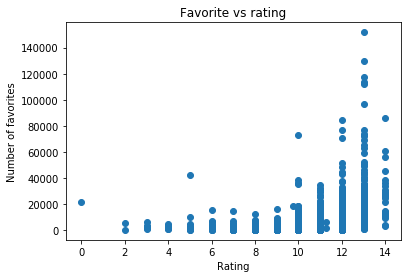

In [42]:
scatter_data = twitter_archive_master[~twitter_archive_master.rating_numerator.isnull()]
#There are unresolved issues with rating numerator, so I will remove those higher than 20 to get a better view
scatter_data = scatter_data[scatter_data.rating_numerator < 20]
plt.scatter(scatter_data.rating_numerator, scatter_data.favorite_count);
plt.title("Favorite vs rating");
plt.xlabel("Rating");
plt.ylabel("Number of favorites");

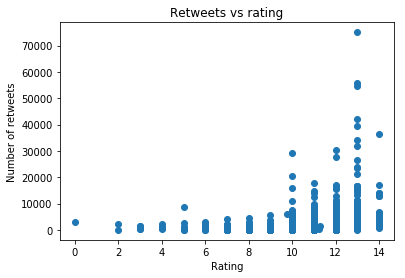

In [43]:
plt.scatter(scatter_data.rating_numerator, scatter_data.retweet_count);
plt.title("Retweets vs rating");
plt.xlabel("Rating");
plt.ylabel("Number of retweets");

We can see that both number of favorites and retweets increases for rankings higher than 9. It is interesting that the highest number of favorites and retweets correspond to dog with a rating of 13. It is posible that the reason for this is that there are more dogs with that rating than dogs with a rating of 14.

# Visualization

Now I am going to create a visualization. I am going to make just one image, although the code could be easily applier to the whole dataframe with a for loop. 
I am going to look for the first dog which has an identifided type and I am going to produce its image with name, type and rating. 

In [45]:
#Find the first no null value for type
first_index = next(i for i, j in enumerate(twitter_archive_master.type) if j)

url = twitter_archive_master.jpg_url[first_index]
r = requests.get(url)
image = Image.open(BytesIO(r.content))
width, height = image.size #I will use these values to position the texts in the proper place
image_editable = ImageDraw.Draw(image)

#Create a string to print the rating
numerator = str(twitter_archive_master.rating_numerator[first_index]).split(".")[0]
denominator = str(twitter_archive_master.rating_denominator[first_index]).split(".")[0]
rating = numerator + "/" + denominator

font_name = ImageFont.truetype("arial.ttf", int(height / 10))
font2 = ImageFont.truetype("arial.ttf", int(height / 12))
image_editable.text((100 ,15), twitter_archive_master.name[first_index], (237, 230, 211),font=font_name)
image_editable.text((int(width/10), height - 200), twitter_archive_master.type[first_index] , (0, 0, 0),font=font2)
image_editable.text((int(width /2), height - 200), rating , (255, 0, 0),font=font2)

image.save("picture.jpg")